# Deepfake detection using GAN


In [227]:
# Imports
import numpy as np
import torch
import torchvision as tv
import math
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib
from tqdm import tqdm


In [228]:
# Configure plots
matplotlib.style.use("seaborn-poster")  # Poster = big, paper = small
matplotlib.style.use("ggplot")
matplotlib.rcParams["font.family"] = "serif"
sns.set_context("poster")  # Poster = big, paper = small


Controlling seeds to control reproducability.


In [229]:
# Paths
train_set = "train/"
test_set = "test_set/"


In [230]:
batch_size = 64  # How many elemnts in each batch
image_size = 64  # Resize images to this value
# Load the real part of the train dataset
train_set_real = tv.datasets.ImageFolder(
    root=train_set + "real",
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

# Use dataloader to get batches
dataloader_real = torch.utils.data.DataLoader(
    train_set_real, batch_size=batch_size, shuffle=True
)

# Load the fake part of the train dataset
train_set_fake = tv.datasets.ImageFolder(
    root=train_set + "fake",
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

# Use dataloader to get batches
dataloader_fake = torch.utils.data.DataLoader(
    train_set_fake, batch_size=batch_size, shuffle=True
)


In [231]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 64
        self.main = torch.nn.Sequential(
            # input is 64 x 64 x 3
            torch.nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


In [232]:
# Custom weights initialization called on the discriminator
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


In [233]:
# Create the Discriminator
network = Discriminator()

# Apply weights
network.apply(init_weights);

In [234]:
def train_on_batch(batch, label):
    # Format batch
    batch = data[0].to()
    labels = torch.full((batch.size(0),), label, dtype=torch.float)

    # Forward pass batch
    output = network(batch).view(-1)

    # Calculate loss on batch
    loss = loss_fn(output, labels)

    # Backwards pass batch
    loss.backward()
    return loss


In [ ]:
# Optimiser
optimiser = torch.optim.Adam(network.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss_fn = torch.nn.BCELoss()

losses = []

for epoch in tqdm(range(5)):
    itfake = iter(dataloader_fake)

    # For each batch in the dataloader
    for i, data in tqdm(enumerate(dataloader_real)):
        # Set gradient to 0
        network.zero_grad()

        # Train with real batch
        loss_real = train_on_batch(data, 1)

        # Train with fake batch
        loss_fake = train_on_batch(next(itfake), 0)

        # Update network
        optimiser.step()

        # Save losses
        loss = loss_real + loss_fake
        losses.append(loss.item())


<AxesSubplot:>

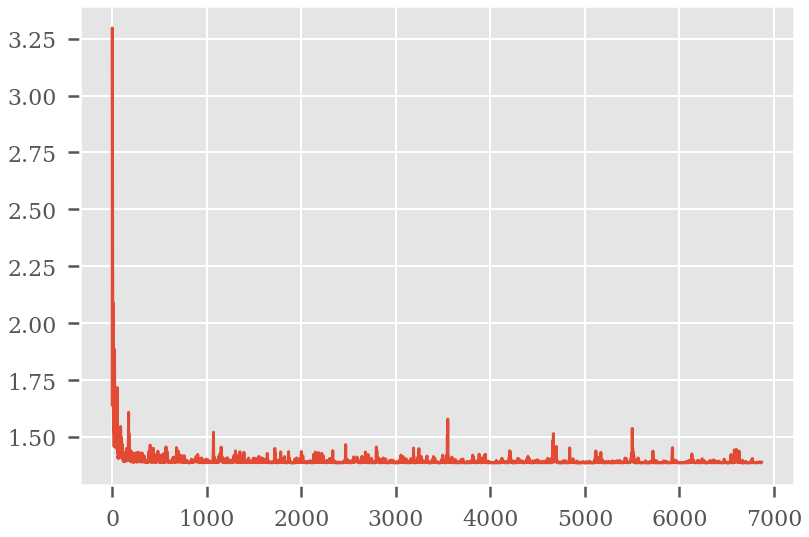

In [ ]:
# Plot losses
sns.lineplot(data=losses)


In [ ]:
# Set network in evaluation mode
network.eval();


In [ ]:
def predict_folder(path):
    total = {}
    videos = tv.datasets.ImageFolder(
        root=path,
        transform=tv.transforms.Compose(
            [
                tv.transforms.Resize(image_size),
                tv.transforms.CenterCrop(image_size),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    for ind, val in tqdm(videos.class_to_idx.items()):
        low = math.inf
        high = -1
        for i, ele in enumerate(videos.imgs):
            _, idx = ele
            if idx == val:
                if i < low:
                    low = i
                if i > high:
                    high = i
        high += 1
        video = torch.utils.data.Subset(videos, range(low, high))
        results = {}
        frame_names = videos.imgs[low:high]
        frame_names = [name[0] for name in frame_names]
        name_iter = iter(frame_names)
        with torch.no_grad():
            for i, frame in enumerate(video):
                frame_name = next(name_iter)
                frame = frame[0]
                frame = frame.view(1, *frame.shape)
                pred = network(frame).item()
                if (
                    i != 0 and not "face0" in frame_name
                ):  # If the face is part of a frame with multiple faces, always select the one most likely to be fake.
                    frame_name = list(results.keys())[-1]
                    results[frame_name] = (
                        pred if pred < results[frame_name] else results[frame_name]
                    )
                else:
                    results[frame_name] = pred
        values = list(results.values())
        total[ind] = round(np.mean(values)) # Classify the video as fake or real based on the majority of the frames.
    return total


In [ ]:
total_real = predict_folder(test_set + "real")


100%|██████████| 14/14 [00:57<00:00,  4.10s/it]


In [236]:
df_real = pd.DataFrame(total_real.values(), total_real.keys())

print(f"Correctly classified videos: {df_real[0].sum()}")
print(f"Incorrectly classified videos: {len(df_real) - df_real[0].sum()}")
print(
    f"Percantage corretly classified: {round((df_real[0].sum() / len(df_real)) * 100, 2)}%"
)


Correctly classified videos: 5
Incorrectly classified videos: 9
Percantage corretly classified: 35.71%


In [ ]:
total_fake = predict_folder(test_set + "fake")


100%|██████████| 256/256 [19:11<00:00,  4.50s/it]


In [ ]:
df_fake = pd.DataFrame(total_fake.values(), total_fake.keys())

print(f"Correctly classified videos: {len(df_fake) - df_fake[0].sum()}")
print(f"Incorrectly classified videos: {df_fake[0].sum()}")
print(
    f"Percantage corretly classified: {round(((len(df_fake) - df_fake[0].sum()) / len(df_fake)) * 100, 2)}%"
)


Correctly classified videos: 126
Incorrectly classified videos: 130
Percantage corretly classified: 49.22%


In [237]:
df_real

,0
aagfhgtpmv.mp4,0
aapnvogymq.mp4,0
abqwwspghj.mp4,0
acqfdwsrhi.mp4,1
acxnxvbsxk.mp4,0
...,...
etdcqxabww.mp4,1
etejaapnxh.mp4,0
etmcruaihe.mp4,0
etohcvnzbj.mp4,1
